# Part A: Probabilistic Gaussian Generative Classifier

In this section, we will implement a generative model for handwritten digit classification. Unlike discriminative models (like Logistic Regression) that try to find a boundary between classes, generative models try to model what each class *looks like* geometrically.

### The Generative Assumption
We assume that the data for each class $k$ (digits $0, \dots, 9$) is generated from a **Gaussian Distribution** (also known as a Normal Distribution). This means each class is a "cloud" of points in the 64-dimensional feature space.

The model is defined by two probabilities:
1.  **The Prior $p(y=k)$**: How likely is it to see digit $k$ in general?
2.  **The Likelihood $p(x|y=k)$**: If we are looking at digit $k$, what is the probability of seeing image features $x$? We model this as a Multivariate Gaussian:
    $$p(x|y=k) = \mathcal{N}(x; \mu_k, \Sigma)$$
    (Notation for the gaussian distribution (N) x-> inputs, mu_k & Sigma are parameters)

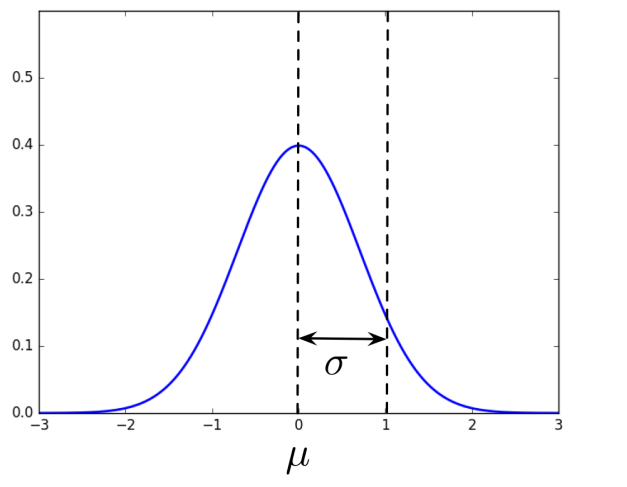
### Key Assumptions for Part A
1.  **Distinct Centers ($\mu_k$)**: Each digit has its own mean image (e.g., the average "0" looks different from the average "1").
2.  **Shared "Shape" ($\Sigma$)**: We assume all classes share the **same** Covariance Matrix $\Sigma$. This means every digit cloud has the same spread and orientation, just shifted to different locations in space. This assumption turns the decision boundaries into straight lines (Linear Discriminant Analysis).

### The Learning Process
To "learn" this model, we simply calculate statistics from our training data:
* $\hat{\pi}_k$: The fraction of training examples that are class $k$.
* $\hat{\mu}_k$: The average vector of all training examples of class $k$.
* $\hat{\Sigma}$: The average shape of the clouds. We calculate this by centering the data (subtracting the class mean from each point) and computing the average outer product.

### The Prediction Rule
To classify a new image $x$, we use Bayes' Rule to find the class with the highest posterior probability. Because we are comparing scores, we can drop the denominator and use log-probabilities for numerical stability:

$$\hat{y} = \arg\max_k \left( \log p(y=k) + \log p(x|y=k) \right)$$

We will also use **regularization** by adding $\lambda I$ to our covariance matrix ($\Sigma_{reg} = \Sigma + \lambda I$). This ensures the matrix is invertible (non-singular) and prevents overfitting.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Set seed for reproducibility
np.random.seed(42)

## A1. Dataset Setup and Splitting

We will use the **Handwritten Digits** dataset. As per the assignment requirements, we need to split the data into 70% Training, 15% Validation, and 15% Test.

To achieve this with `train_test_split` (which usually splits into just two sets), we will perform a two-step split:
1.  Split **Data** into **Train_Full** (85%) and **Test** (15%).
2.  Split **Train_Full** into **Train** (~82.4%) and **Validation** (~17.6%).
    * *Note:* $0.176 \times 0.85 \approx 0.15$ of the total original data.

We will also **stratify** the split to ensure every set has an equal proportion of digits (0-9). Finally, we standardize the features so they have mean 0 and variance 1, which helps with Gaussian modeling.

In [4]:
# 1. Load Data
digits = load_digits()
X, y = digits.data, digits.target

# 2. First Split: Separate out the Test set (15%)
# We use stratification to maintain class balance
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

# 3. Second Split: Separate Validation from the Training set
# We need the validation set to be 15% of the ORIGINAL total.
# We currently have 85% of the data. 15 / 85 ~= 0.1765
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1765, stratify=y_train_full, random_state=42
)

# 4. Standardize Features
scaler = StandardScaler()
# Fit ONLY on training data to avoid data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Transform validation and test using the training scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Training Shape: {X_train_scaled.shape} ({X_train_scaled.shape[0]/X.shape[0]:.2%} of total)")
print(f"Validation Shape: {X_val_scaled.shape} ({X_val_scaled.shape[0]/X.shape[0]:.2%} of total)")
print(f"Test Shape: {X_test_scaled.shape} ({X_test_scaled.shape[0]/X.shape[0]:.2%} of total)")

Training Shape: (1257, 64) (69.95% of total)
Validation Shape: (270, 64) (15.03% of total)
Test Shape: (270, 64) (15.03% of total)


## A2. Implementing the Gaussian Generative Model

Here we implement the class `GaussianGenerativeModel`.

**Key Mathematical Details for Implementation:**

**1. Covariance Estimation:**
The assignment asks us to calculate the shared covariance $\Sigma$ manually by accumulating $(x_i - \mu_{y_i})(x_i - \mu_{y_i})^T$ for all samples. This measures how data varies *relative to its own class center*, ignoring the distance between different classes.

**2. The Log-Likelihood Score:**
For the prediction step, we need to calculate $\log \mathcal{N}(x; \mu_k, \Sigma_\lambda)$.
Recall the PDF of a Multivariate Gaussian:
$$\mathcal{N}(x; \mu, \Sigma) = \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}} \exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\right)$$
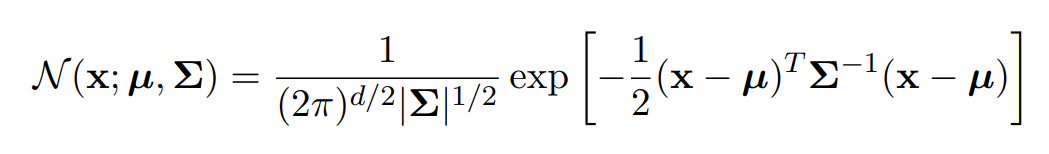

Taking the log gives us:
$$\log \mathcal{N} = -\frac{D}{2}\log(2\pi) - \frac{1}{2}\log|\Sigma| - \frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)$$

Proof:

#### Apply the Natural Logarithm ($\log$)
We take the log of both sides. Recall the product rule for logarithms: $\log(A \cdot B) = \log(A) + \log(B)$.

$$
\log p(x) = \log\left( \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}} \right) + \log\left( \exp\left(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)\right) \right)
$$

#### Simplify the Exponential Term (Term B)
Recall the inverse log rule: $\log(e^z) = z$. The log cancels out the exponential function completely.

$$
\text{Term B} = -\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)
$$

#### Simplify the Normalization Constant (Term A)
Now let's look at the first term. Recall the quotient rule: $\log(\frac{1}{C}) = \log(1) - \log(C)$. Since $\log(1) = 0$, this becomes $-\log(C)$.

$$
\text{Term A} = \log\left( \frac{1}{(2\pi)^{D/2}|\Sigma|^{1/2}} \right) = -\log\left( (2\pi)^{D/2} \cdot |\Sigma|^{1/2} \right)
$$

Now apply the product rule again inside the parentheses: $\log(X \cdot Y) = \log(X) + \log(Y)$.

$$
\text{Term A} = -\left[ \log\left( (2\pi)^{D/2} \right) + \log\left( |\Sigma|^{1/2} \right) \right]
$$

#### Apply Power Rules
Recall the power rule: $\log(X^n) = n \cdot \log(X)$.

1.  For the dimensions: $\log\left( (2\pi)^{D/2} \right) \rightarrow \frac{D}{2} \log(2\pi)$
2.  For the determinant: $\log\left( |\Sigma|^{1/2} \right) \rightarrow \frac{1}{2} \log|\Sigma|$

Substitute these back into Term A:

$$
\text{Term A} = -\left[ \frac{D}{2} \log(2\pi) + \frac{1}{2} \log|\Sigma| \right] = -\frac{D}{2} \log(2\pi) - \frac{1}{2} \log|\Sigma|
$$

#### Step 6: Combine All Terms
Putting Term A and Term B back together gives us the final log-likelihood equation used in our model:

$$
\log \mathcal{N} = \underbrace{-\frac{D}{2}\log(2\pi) - \frac{1}{2}\log|\Sigma|}_{\text{Normalization Constant}} \underbrace{- \frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu)}_{\text{Mahalanobis Distance}}
$$

Since $\Sigma$ is **shared** across all classes, the terms $-\frac{D}{2}\log(2\pi)$ and $-\frac{1}{2}\log|\Sigma|$ are constant for every class. When comparing scores (argmax), constants don't matter! We can simplify our score for class $k$ to:

$$\text{Score}_k = \log(\pi_k) - \frac{1}{2}(x-\mu_k)^T \Sigma_\lambda^{-1} (x-\mu_k)$$

This is much faster and numerically stable to compute.

In [ ]:
class GaussianGenerativeModel:
    def __init__(self, lambda_reg=1e-2):
        self.lambda_reg = lambda_reg
        self.priors = {}
        self.means = {}
        self.shared_cov = None
        self.inv_cov = None # Pre-compute inverse for speed
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_samples, n_features = X.shape
        
        # Initialize pooled covariance matrix as zeros
        weighted_cov_sum = np.zeros((n_features, n_features))
        
        # Step 1 & 2: Calculate Priors and Means
        for k in self.classes:
            # Filter samples for this class
            X_k = X[y == k]
            
            # Prior: count / total
            self.priors[k] = len(X_k) / n_samples
            
            # Mean: average of features
            self.means[k] = np.mean(X_k, axis=0)
            
            # Accumulate covariance terms
            # Calculate (x - mu_k)
            centered_data = X_k - self.means[k]
            
            # Accumulate (x - mu)(x - mu)^T
            # This dot product effectively sums the outer products for all samples in X_k
            weighted_cov_sum += np.dot(centered_data.T, centered_data)
            
        # Step 3: Normalize shared covariance
        self.shared_cov = weighted_cov_sum / n_samples
        
        # Step 4: Regularize Covariance (Sigma + lambda*I)
        # This fixes "singular matrix" errors if features are constant
        identity = np.eye(n_features)
        self.regularized_cov = self.shared_cov + (self.lambda_reg * identity)
        
        # Pre-compute inverse for prediction speed
        self.inv_cov = np.linalg.inv(self.regularized_cov)
        
    def predict(self, X):
        predictions = []
        
        # For every single image x in the input X...
        for x in X:
            scores = {}
            
            # Calculate score for each class k
            for k in self.classes:
                # 1. Log Prior term
                log_prior = np.log(self.priors[k])
                
                # 2. Log Likelihood term (Mahalanobis distance part)
                # diff = (x - mu_k)
                diff = x - self.means[k]
                
                # term = -0.5 * (x-mu)^T * Sigma^-1 * (x-mu)
                mahalanobis = np.dot(np.dot(diff.T, self.inv_cov), diff)
                log_likelihood = -0.5 * mahalanobis
                
                # Total Score
                scores[k] = log_prior + log_likelihood
            
            # Pick class with max score
            best_class = max(scores, key=scores.get)
            predictions.append(best_class)
            
        return np.array(predictions)

## A3. Hyperparameter Tuning

We need to tune $\lambda$ (covariance regularization strength). This parameter controls how much we "smooth" the covariance matrix.
* **Small $\lambda$**: The model trusts the data strictly (low bias, high variance).
* **Large $\lambda$**: The model ignores subtle correlations and assumes a spherical shape (high bias, low variance).

[cite_start]We will train on the **Training Set** and evaluate on the **Validation Set** for different $\lambda$ values [cite: 1545-1549].

In [ ]:
# Candidate values for lambda 
lambda_values = [1e-4, 1e-3, 1e-2, 1e-1]
results = {}

print(f"{'Lambda':<10} | {'Val Accuracy':<10}")
print("-" * 25)

best_acc = 0
best_lambda = None

for l in lambda_values:
    # 1. Create and Train
    model = GaussianGenerativeModel(lambda_reg=l)
    model.fit(X_train_scaled, y_train)
    
    # 2. Evaluate on Validation
    y_pred_val = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, y_pred_val)
    
    results[l] = acc
    print(f"{l:<10} | {acc:.4f}")
    
    # Keep track of best
    if acc > best_acc:
        best_acc = acc
        best_lambda = l

print("-" * 25)
print(f"Best Lambda found: {best_lambda}")

Lambda     | Val Accuracy
-------------------------
0.0001     | 0.9481
0.001      | 0.9481
0.01       | 0.9519
0.1        | 0.9444
-------------------------
Best Lambda found: 0.01


## Final Evaluation

Now that we have the best $\lambda$, we perform the final evaluation steps:
1.  Combine Training and Validation sets.
2.  Retrain the model on this combined set using `best_lambda`.
3.  Evaluate **once** on the Test set.
4.  Report Accuracy, Macro Precision/Recall/F1, and Confusion Matrix.

Final Test Evaluation
Accuracy: 0.9481

Classification Report (Macro-averaged):
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        27
           1     0.7742    0.8889    0.8276        27
           2     1.0000    0.9259    0.9615        27
           3     0.9655    1.0000    0.9825        28
           4     0.9643    1.0000    0.9818        27
           5     1.0000    1.0000    1.0000        27
           6     1.0000    0.9630    0.9811        27
           7     0.9643    1.0000    0.9818        27
           8     0.9130    0.8077    0.8571        26
           9     0.9231    0.8889    0.9057        27

    accuracy                         0.9481       270
   macro avg     0.9504    0.9474    0.9479       270
weighted avg     0.9506    0.9481    0.9484       270



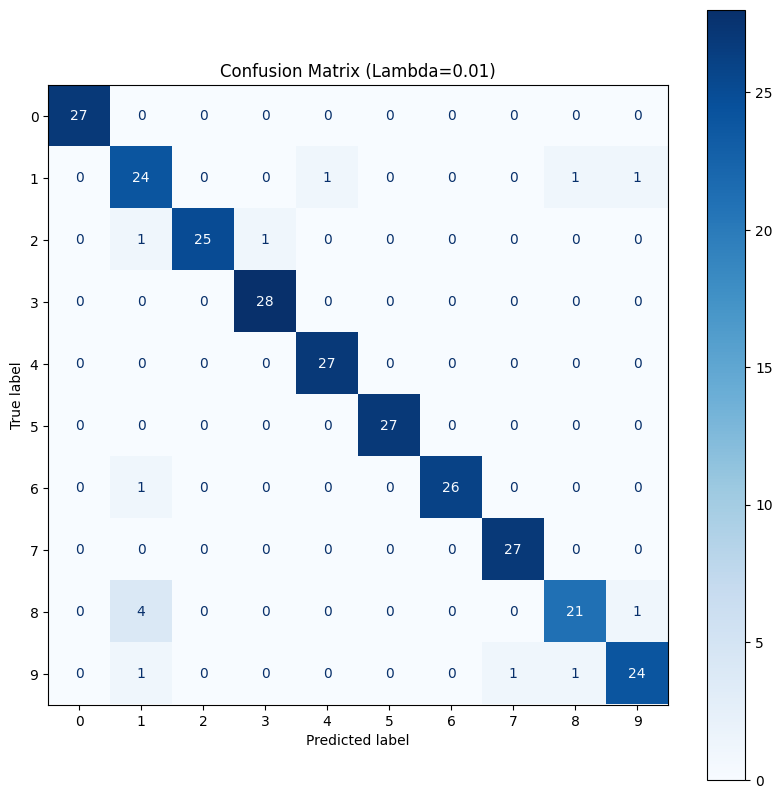

In [7]:
# 1. Combine Train and Val
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.hstack((y_train, y_val))

# 2. Retrain final model
final_model = GaussianGenerativeModel(lambda_reg=best_lambda)
final_model.fit(X_combined, y_combined)

# 3. Predict on Test set
y_pred_test = final_model.predict(X_test_scaled)

# 4. Report Metrics
print("Final Test Evaluation")
print("=====================")
print(f"Accuracy: {accuracy_score(y_test, y_pred_test):.4f}\n")

print("Classification Report (Macro-averaged):")
print(classification_report(y_test, y_pred_test, digits=4))

# 5. Confusion Matrix
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues')
plt.title(f"Confusion Matrix (Lambda={best_lambda})")
plt.show()